# Place Cell Analyses

Analyze TH data for place cells.

Cells of interest:
- No cells show clear / traditional place cell responses

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO

from spiketools.spatial.occupancy import (compute_occupancy, compute_spatial_bin_edges,
                                          compute_spatial_bin_assignment)
from spiketools.spatial.utils import get_pos_ranges, get_bin_width
from spiketools.spatial.information import compute_spatial_information_2d

from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import zscore_to_surrogates, compute_empirical_pvalue

from spiketools.plts.space import plot_positions, plot_space_heat
from spiketools.plts.stats import plot_surrogates

from spiketools.utils import restrict_range

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from analysis import get_spike_positions

## Functions

In [5]:
def compute_bin_firing(x_binl, y_binl, bins):
    """Compute firing per bin, givin bin assignment of each spike."""
    
    bin_firing = np.zeros(bins)
    for x_bl, y_bl in zip(x_binl, y_binl):
        bin_firing[x_bl - 1, y_bl - 1] += 1
        
    return bin_firing

## Settings

In [6]:
# Define bins to use
bins = [7, 21]

# Set which example unit to extract
uind = 21

In [7]:
# Shuffle Settings
shuffle_approach = 'BINCIRC'
n_surrogates = 100

## Load Data

In [8]:
# Load NWB file
io = NWBHDF5IO('nwb_local_data.nwb', 'r')
nwbfile = io.read()

In [9]:
# Extract the position data
pos = nwbfile.acquisition['position']['xy_position']
ptimes = pos.timestamps[:]
positions = pos.data[:]

In [10]:
# Check how many units are available
n_units = len(nwbfile.units)
print('Number of units: {}'.format(n_units))

Number of units: 81


In [11]:
# Extract spikes for a unit of interest
spikes = nwbfile.units.get_unit_spike_times(uind)
spikes = spikes / 1000

In [12]:
# Drop spikes until task time
st = nwbfile.trials['start_time'][0]
en = nwbfile.trials['stop_time'][-1]
spikes = restrict_range(spikes, st, en)

## Position Data

In [13]:
# Compute position ranges
x_range, y_range = get_pos_ranges(positions)

In [14]:
# Check ranges of positon
print('Position X-range:  {:1.2f} - {:1.2f} ({:1.2f})'.format(*x_range, x_range[1] - x_range[0]))
print('Position Y-range:  {:1.2f} - {:1.2f} ({:1.2f})'.format(*y_range, y_range[1] - y_range[0]))

Position X-range:  365.40 - 404.59 (39.18)
Position Y-range:  285.00 - 433.00 (148.00)


In [15]:
# Get position values for each spike
spike_xs, spike_ys = get_spike_positions(spikes, ptimes, positions)
spike_positions = np.array([spike_xs, spike_ys])

In [16]:
# Check binning
x_bin_edges, y_bin_edges = compute_spatial_bin_edges(positions, bins)

In [17]:
# Check bin sizes
print('Bin widths: {:1.2f}, {:1.2f}'.format(get_bin_width(x_bin_edges), get_bin_width(y_bin_edges)))

Bin widths: 5.60, 7.05


### Occupancy

In [18]:
# Compute occupancy
occ = compute_occupancy(positions, ptimes, bins)

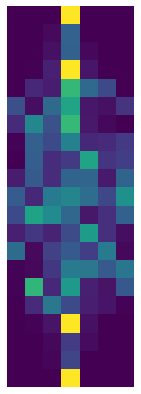

In [19]:
# Plot occupancy
plot_space_heat(occ, transpose=True, vmax=25, ignore_zero=False, figsize=(5, 7))

## Check spike locations

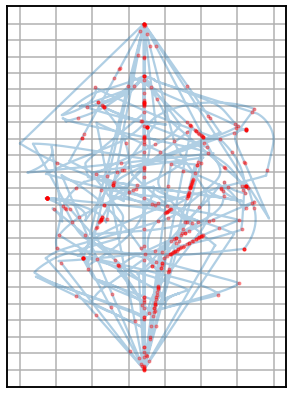

In [20]:
# Plot the map across all position traces
plot_positions(positions, spike_positions, x_bins=x_bin_edges, y_bins=y_bin_edges, figsize=(5, 7))

## Compute Binned Spatial Firing

In [21]:
# Compute spatial bin assignments for each spike
x_binl, y_binl = compute_spatial_bin_assignment(spike_positions, x_bin_edges, y_bin_edges)

In [22]:
# Compute summary map of bin firing
bin_firing = compute_bin_firing(x_binl, y_binl, bins)

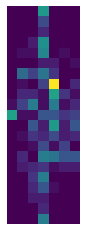

In [23]:
# Check the firing map
plot_space_heat(bin_firing, transpose=True)

In [24]:
# Normalize bin firing by occupancy
normed_bin_firing = bin_firing / occ

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_91399/2429119309.py:2: RuntimeWarning: invalid value encountered in true_divide
  normed_bin_firing = bin_firing / occ


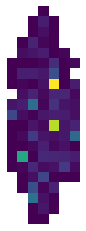

In [25]:
# Plot occupancy-normalized spatial firing
plot_space_heat(normed_bin_firing, transpose=True)

## Compute Spatial Information

In [26]:
# Compute the spatial information
spike_info = compute_spatial_information_2d(spike_xs, spike_ys, [x_bin_edges, y_bin_edges], occ)
print(spike_info)

1.7534446880774668


In [27]:
# Create shuffled time series for comparison
#   Note: some temporary quirks here to deal with UNIX time
temp = spikes - st
times_shuffle = shuffle_spikes(temp, shuffle_approach, n_surrogates)
times_shuffle = times_shuffle + st

In [28]:
# Compute spatial information measures on surrogates
surrs = np.zeros(n_surrogates)
for ind, stimes in enumerate(times_shuffle):    
    
    spike_xs, spike_ys = get_spike_positions(stimes, ptimes, positions)
    surrs[ind] = compute_spatial_information_2d(spike_xs, spike_ys, [x_bin_edges, y_bin_edges], occ)

In [29]:
# Compute the empirical p-value based on surrogates
surr_p_val = compute_empirical_pvalue(spike_info, surrs)

# Compute z-score of spatial information compared to surrogates
z_score = zscore_to_surrogates(spike_info, surrs)

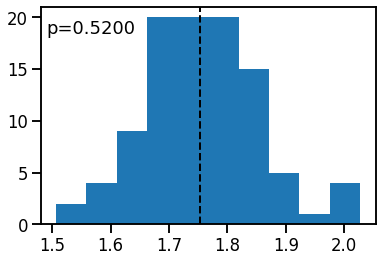

In [30]:
# Plot distribution of surrogates with measured empirical value
plot_surrogates(surrs, spike_info, surr_p_val)

## All Cells

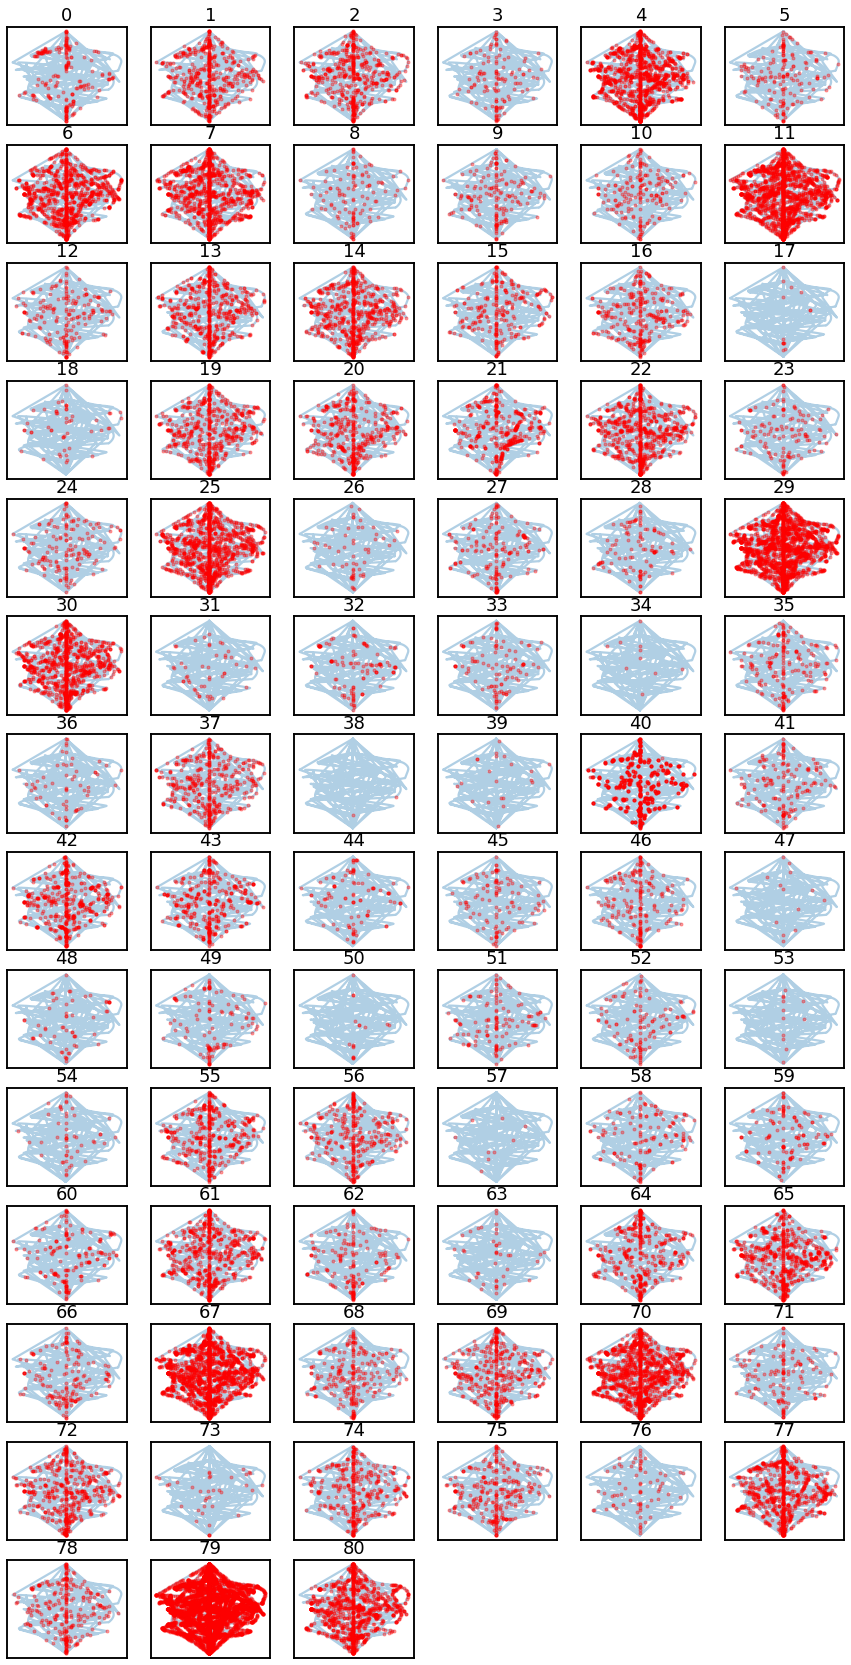

In [31]:
# Examine spatial firing across all cells
_, axes = plt.subplots(14, 6, figsize=(15, 30))
for uind, ax in zip(range(n_units), axes.flatten()):
    
    spikes = nwbfile.units.get_unit_spike_times(uind) / 1000
    
    spike_xs, spike_ys = get_spike_positions(spikes, ptimes, positions)
    
    plot_positions(positions, np.array([spike_xs, spike_ys]), ax=ax)
    ax.set_title(uind)
for ii in range(n_units, len(axes.flatten())):
    axes.flatten()[ii].set_axis_off()